In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
from lib.GaussianMixture import *

## Model
This is a simple bi-modal model of data $x_i\in \mathbb{R}$ wich is distributed by two unit-variance gaussian with parametrised means.

In [20]:
def normal(x, my = 0., sigma = 1.):
    return 1/tf.sqrt(2*np.pi)/sigma * tf.exp(-0.5 * ((x - my)/sigma)**2)

In [21]:
def log_normal(x, my = 0., sigma = 1.):
    return tf.math.log(1/tf.sqrt(2*np.pi)/sigma) - 0.5 * ((x - my)/sigma)**2

In [22]:
#shape(x) = (N_data, datashape...)
#shape(theta) = (1, N_theta, thetashape...)
def log_joint_dist(x, theta):
    return tf.math.log(0.5 * normal(x, my = theta[:,:,0], sigma = 1) + 0.5 * normal(x, my = theta[:,:,1], sigma = 1))

In [23]:
def log_joint_dist_combined(x, theta):
    return tf.reduce_sum(log_joint_dist(x, theta), axis = 0)

In [24]:
##Broadcasting usage

# x_hat = tf.random.normal(shape = (100,1), mean = -2, stddev = 1)
# print(x_hat.shape)

# sample = tf.expand_dims(variational_dist.dist.sample(20), axis = 0)
# print(sample.shape)

# logp = log_joint_dist(x_hat, sample)
# print(logp.shape)

## Observation
This samples from our model mith $\mathrm{means} = [2.3, -3.3]$.

In [30]:
x_hat1 = tf.random.normal(shape = (24,1), mean = 2.3, stddev = 1)
x_hat2 = tf.random.normal(shape = (24,1), mean = -3.3, stddev = 1)
x_hat = tf.concat((x_hat1, x_hat2), axis = 0)

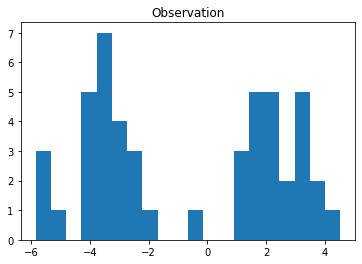

In [31]:
plt.hist(x_hat.numpy(), bins = 20)
plt.title("Observation")
plt.show()

## Visualisation of analytical posterior

In [13]:
res = 30
logp = np.zeros(shape = (res,res))
for i in range(res):
    for j in range(res):
        x = i/res * 10 - 5
        y = j/res * 10 - 5
        logp[i,j] = log_joint_dist_combined(x_hat, tf.constant([[[x,y]]]))

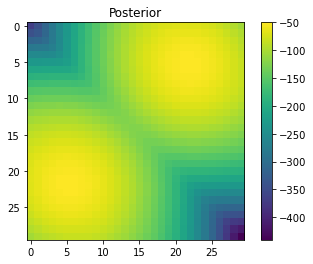

In [14]:
plt.imshow(logp.T)
plt.title("Posterior")
plt.colorbar()
plt.show()

## Variational Inference

2D Gaussian Mixture of 6 components is used to fit the above distribution.

In [15]:
#This uses our library
#Gaussian Mixture is a trainable gaussian mixture distribution with variable number of components. The categoric propabilities,
#the means and variances are parametrised by variables and can be differentiated to.
variational_dist = GaussianMixture(dimensions = 2, n_components = 6)

In [27]:
#Objective funtion to maximise is ELBO between the joint and the variational distribution. This minimises at the same time
#the KL-divergence between our variational distribution and the analytical posterior.
def ELBO(N = 1):
    theta_sample = tf.expand_dims(variational_dist.dist.sample(N), axis = 0)
    
    elbo = log_joint_dist_combined(x_hat, theta_sample) - variational_dist.dist.log_prob(theta_sample)
    return tf.reduce_mean(elbo)

In [28]:
print("ELBO:", ELBO().numpy())

ELBO: -98.05661


In [32]:
### Training
opt = tf.optimizers.Adam(learning_rate=0.05)
loss = tf.function(lambda: -ELBO(20))
for i in range(int(1200)):
    opt.minimize(loss, variational_dist.trainable_variables)
    if i % 50 == 0:
        print("ELBO:", ELBO(10))

ELBO: tf.Tensor(-104.97367, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.38729, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.394775, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.18501, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.45876, shape=(), dtype=float32)
ELBO: tf.Tensor(-103.69585, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.55906, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.249146, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.39899, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.430466, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.35535, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.33794, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.3195, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.29344, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.28853, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.36104, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.28999, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.31566, shape=(), dtype=float32)
ELBO: tf.Tensor(-104.36769, shape=(), dtype=

### Variational Posterior Visualisation

Text(0.5, 1.0, 'Variational Posterior')

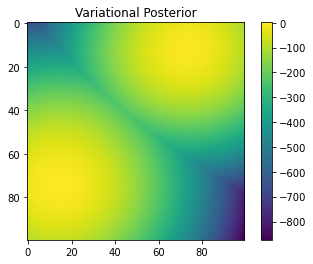

In [33]:
xx, yy = tf.meshgrid(tf.linspace(-5,5,100), tf.linspace(-5,5,100))
thetas = tf.cast(tf.stack((xx, yy), axis = 2), dtype = "float32")

img = variational_dist.dist.log_prob(thetas)

plt.imshow(img.numpy())
plt.colorbar()
plt.title("Variational Posterior")